<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Visualizing_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageDraw,ImageFont,ImageColor,ImageOps
import numpy as np
from six import BytesIO
import matplotlib.pyplot as plt
import tempfile
import time
from six.moves.urllib.request import urlopen

In [51]:
module_handle = 'https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1'

In [52]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [53]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7EFD00A42750>}))

In [54]:
detector = model.signatures['default']

In [55]:
def display_image(image):
  plt.figure(figsize = (20,7))
  plt.grid(False)
  plt.imshow(image)
  
def download_and_resize_image(url,new_width = 256,new_height =256 ,display = False):
  _,filename  = tempfile.mkstemp(suffix = '.jpg')
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image,(new_width,new_height),Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename , format = 'JPEG' , quality = 90)
  print("Image downloaded to {}".format(filename))
  if display:
    display_image(pil_image)
  return filename

Image downloaded to /tmp/tmpx01dizv3.jpg


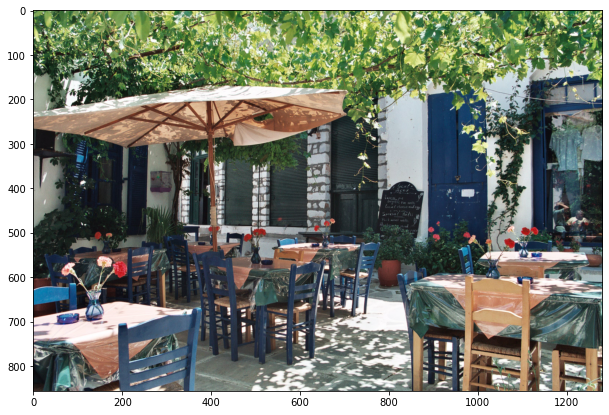

In [56]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [79]:
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness = 4 , display_str_list = ()):
  draw = ImageDraw.Draw(image)
  im_width , im_height = image.size
  (left,right,top,bottom) = (xmin*im_width  ,xmax*im_width , ymin*im_height,ymax*im_height)
  draw.line([(left,top) , (left,bottom) , (right,bottom) , (right,top),(left,top)],width= thickness , fill = color)
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1+2*0.05) * sum(display_str_heights)

  if top>total_display_str_height:
    text_bottom = top
  else:
    text_bottom  = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width , text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)

    draw.rectangle([(left,text_bottom - text_height - 2*margin),
                    (left+text_width , text_bottom)],
                    fill = color)
    draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
    
    text_bottom -= text_height  - 2*margin

def draw_boxes(image,boxes,class_names,scores,max_boxes = 10,min_scores = 0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    
  except IOError:
    print("Font not found , using default font")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0],max_boxes)):
    if scores[i] >= min_scores:
      ymin , xmin,ymax,xmax = tuple(boxes[i])
      display_str = "{}.{}%" .format(class_names[i].decode('ascii'),
                                      int(100*scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list = [display_str])
      np.copyto(image,np.array(image_pil))
  return image

In [80]:
def load_img(path):
  img = tf.io.read_file(path)
  img  = tf.image.decode_jpeg(img,channels = 3)
  return img

In [81]:
def run_detector(detector,path):
  img = load_img(path)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  print("Found %d objects : " % len(result["detection_scores"]))
  print("Inference time" , end_time - start_time)

  image_with_boxes = draw_boxes(img.numpy(),result["detection_boxes"],
                                result["detection_class_entities"],
                                result['detection_scores'])
  display_image(image_with_boxes)

Found 100 objects : 
Inference time 0.8168389797210693


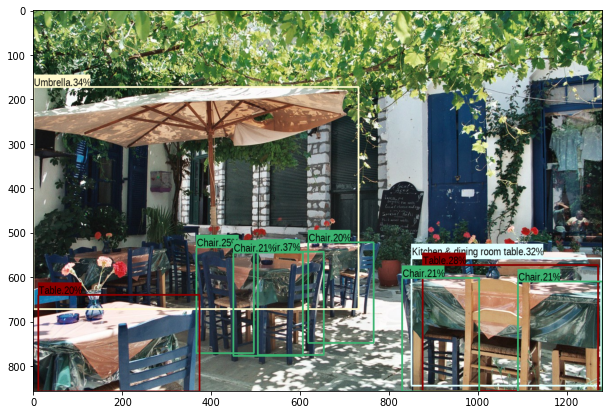

In [82]:
run_detector(detector, downloaded_image_path)

In [83]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpfd7x4910.jpg
Found 100 objects : 
Inference time 0.6686973571777344
Inference time: 0.9986581802368164


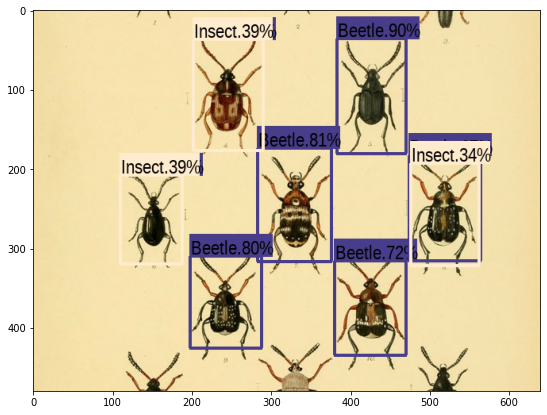

In [84]:
detect_img(image_urls[0])

Image downloaded to /tmp/tmpg8dmi72k.jpg
Found 100 objects : 
Inference time 0.6737475395202637
Inference time: 0.9385161399841309


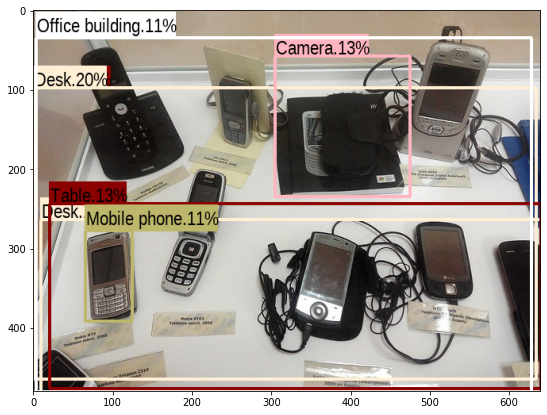

In [85]:
detect_img(image_urls[1])

Image downloaded to /tmp/tmpd1edn2wk.jpg
Found 100 objects : 
Inference time 0.6732938289642334
Inference time: 1.0705132484436035


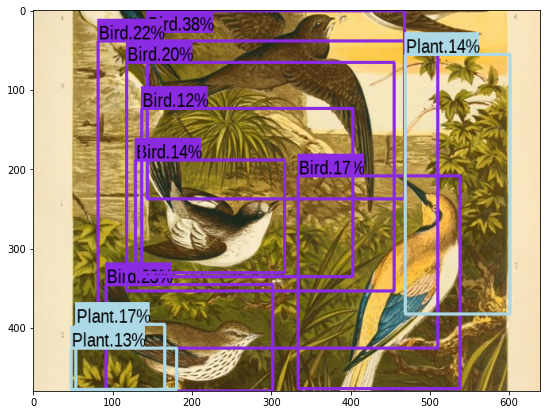

In [86]:
detect_img(image_urls[2])